In [1]:
import numpy as np
from pathlib import Path
import os
from sklearn.model_selection import ParameterGrid
import pandas as pd

root = Path('/hpc/group/kamaleswaranlab/EmoryDataset/Images/chest_xrays')
embedding_path = root / 'BioMedCLIP_embeddings'
dimreduce = root / 'dimReduce'

In [2]:
embeddding_matrix = np.load(embedding_path / 'embedding_matrix.npy')

In [3]:
#UMAP
param_range = {
            'n_neighbors': [20, 25, 30,  35, 40, 45, 50],
            'min_dist': [0.1, 0.3, 0.5],
            'metric': ['manhattan', 'euclidean']
        }
params = ParameterGrid(param_range)

In [29]:
list(zip(range(len(params)), params))

[(0, {'metric': 'manhattan', 'min_dist': 0.1, 'n_neighbors': 20}),
 (1, {'metric': 'manhattan', 'min_dist': 0.1, 'n_neighbors': 25}),
 (2, {'metric': 'manhattan', 'min_dist': 0.1, 'n_neighbors': 30}),
 (3, {'metric': 'manhattan', 'min_dist': 0.1, 'n_neighbors': 35}),
 (4, {'metric': 'manhattan', 'min_dist': 0.1, 'n_neighbors': 40}),
 (5, {'metric': 'manhattan', 'min_dist': 0.1, 'n_neighbors': 45}),
 (6, {'metric': 'manhattan', 'min_dist': 0.1, 'n_neighbors': 50}),
 (7, {'metric': 'manhattan', 'min_dist': 0.3, 'n_neighbors': 20}),
 (8, {'metric': 'manhattan', 'min_dist': 0.3, 'n_neighbors': 25}),
 (9, {'metric': 'manhattan', 'min_dist': 0.3, 'n_neighbors': 30}),
 (10, {'metric': 'manhattan', 'min_dist': 0.3, 'n_neighbors': 35}),
 (11, {'metric': 'manhattan', 'min_dist': 0.3, 'n_neighbors': 40}),
 (12, {'metric': 'manhattan', 'min_dist': 0.3, 'n_neighbors': 45}),
 (13, {'metric': 'manhattan', 'min_dist': 0.3, 'n_neighbors': 50}),
 (14, {'metric': 'manhattan', 'min_dist': 0.5, 'n_neighbor

In [ ]:
idx = 26
nn = params[idx]['n_neighbors']
min_dist = params[idx]['min_dist']
metric = params[idx]['metric']
umap_embeddings = pd.read_csv(dimreduce / f'umap_{nn}_{min_dist}_{metric}.csv')
fig, ax = plot_umap(umap_embeddings.values, title=f'umap_{nn}_{min_dist}_{metric}', figsize = (5,5))

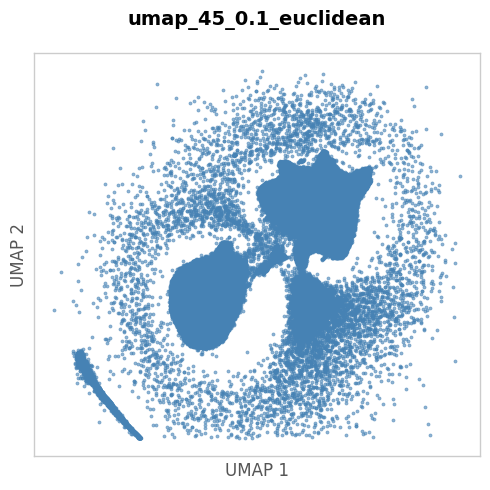

In [67]:
clean_embeddings, mask = remove_umap_outliers(umap_embeddings.values, method='iqr', threshold=1.5)
fig, ax = plot_umap(clean_embeddings, title=f'umap_{nn}_{min_dist}_{metric}', figsize = (5,5))

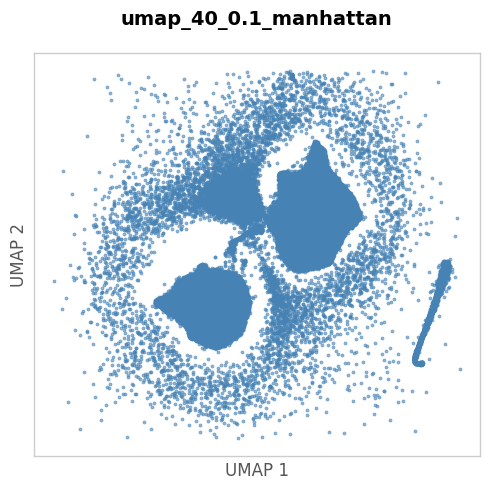

In [63]:
clean_embeddings, mask = remove_umap_outliers(umap_embeddings.values, method='iqr', threshold=1.5)
fig, ax = plot_umap(clean_embeddings, title=f'umap_{nn}_{min_dist}_{metric}', figsize = (5,5))

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


def remove_umap_outliers(embeddings, method='zscore', threshold=3):
    """
    Remove outliers from UMAP embeddings using various methods.
    
    Parameters:
    -----------
    embeddings : np.ndarray
        2D array of shape (n_samples, 2) containing UMAP embeddings
    method : str, default='zscore'
        Method to use for outlier detection:
        - 'zscore': Remove points beyond z standard deviations
        - 'iqr': Remove points beyond IQR * threshold
        - 'isolation_forest': Use Isolation Forest algorithm
    threshold : float, default=3
        Threshold for outlier detection
        
    Returns:
    --------
    clean_embeddings : np.ndarray
        Embeddings with outliers removed
    mask : np.ndarray
        Boolean mask indicating which points were kept
    """
    
    if method == 'zscore':
        # Calculate z-scores for each dimension
        z_scores = np.abs(stats.zscore(embeddings))
        mask = np.all(z_scores < threshold, axis=1)
        
    elif method == 'iqr':
        # Calculate IQR for each dimension
        Q1 = np.percentile(embeddings, 25, axis=0)
        Q3 = np.percentile(embeddings, 75, axis=0)
        IQR = Q3 - Q1
        
        # Create bounds
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        
        # Create mask for points within bounds
        mask = np.all((embeddings >= lower_bound) & (embeddings <= upper_bound), axis=1)
        
    elif method == 'isolation_forest':
        from sklearn.ensemble import IsolationForest
        iso_forest = IsolationForest(contamination=0.1, random_state=42)
        mask = iso_forest.fit_predict(embeddings) == 1
        
    else:
        raise ValueError(f"Unknown method: {method}")
    
    clean_embeddings = embeddings[mask]
    
    return clean_embeddings, mask

def plot_umap(embeddings, 
              labels=None, 
              colors=None,
              figsize=(12, 8),
              point_size=5,
              alpha=0.6,
              title="UMAP Visualization",
              save_path=None,
              random_state=42):
    """
    Create a beautiful UMAP scatter plot.
    
    Parameters:
    -----------
    embeddings : np.ndarray
        2D array of shape (n_samples, 2) containing UMAP embeddings
    labels : array-like, optional
        Labels for coloring the points. If None, all points will be same color
    colors : list or str, optional
        Colors to use for different labels. If None, uses default color palette
    figsize : tuple, default=(12, 8)
        Size of the figure (width, height)
    point_size : int, default=5
        Size of the scatter points
    alpha : float, default=0.6
        Transparency of points (0 to 1)
    title : str, default="UMAP Visualization"
        Title of the plot
    save_path : str, optional
        If provided, saves the plot to this path
    random_state : int, default=42
        Random state for reproducibility
    """
    
    # Set style
    plt.style.use('ggplot')
    np.random.seed(random_state)
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Set background color
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    
    # Plot points
    if labels is not None:
        # If colors not provided, use a nice color palette
        if colors is None:
            colors = sns.color_palette("husl", n_colors=len(np.unique(labels)))
        
        # Create scatter plot for each label
        for idx, label in enumerate(np.unique(labels)):
            mask = labels == label
            ax.scatter(embeddings[mask, 0], 
                      embeddings[mask, 1],
                      c=[colors[idx]],
                      s=point_size,
                      alpha=alpha,
                      label=str(label))
        
        # Add legend
        ax.legend(bbox_to_anchor=(1.05, 1), 
                 loc='upper left', 
                 borderaxespad=0,
                 frameon=True)
    else:
        # Single color plot if no labels
        ax.scatter(embeddings[:, 0],
                  embeddings[:, 1],
                  c='steelblue',
                  s=point_size,
                  alpha=alpha)
    
    # Customize plot
    ax.set_title(title, pad=20, size=14, fontweight='bold')
    ax.set_xlabel('UMAP 1', size=12)
    ax.set_ylabel('UMAP 2', size=12)
    
    # Remove ticks but keep grid
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Add subtle spines
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('#CCCCCC')
    
    # Adjust layout
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
    return fig, ax